In [100]:
!pip install xgboost
!pip install graphviz 
!pip install tensorflow

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
%load_ext autoreload
%autoreload 2
from modules.PlottingUtils import plot_cm
from modules.PreProcessingUtils import GetDummies, split_train_test, sample_cat
from modules.PipelineUtils import NumericalCategoricalSelector, DimensionReducer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [3]:
#classifier dependencies
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score

In [4]:
import tensorflow as tf
from tensorflow import keras

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

In [5]:
tv_df = pd.read_pickle(r'E:\entrevistas\dataset\tv_final.pkl')
#tv_df = pd.read_pickle('./data/tv_final.pkl')

# Feature engineering

In [6]:
from datetime import datetime
from dateutil.relativedelta import relativedelta


def date(row):
    s_registration_timestamp = pd.Timestamp(row['seller_registration_date']).tz_convert(None)
    row['seller_registration_year'] = s_registration_timestamp.year
    row['seller_registration_month'] = s_registration_timestamp.month
    row['seller_registration_day'] = s_registration_timestamp.month
    
    now = datetime.now()
    end_date = datetime.fromtimestamp(datetime.now().timestamp())
    try:
        #if timestamp is none
        start_date = datetime.fromtimestamp(s_registration_timestamp.timestamp())
        
        difference_in_years = relativedelta(end_date, start_date).years
        difference_in_months = relativedelta(end_date, start_date).months
        #difference_in_days = relativedelta(end_date, start_date).days

        month_diff = difference_in_years * 12 + difference_in_months

        row['seller_years_active'] = difference_in_years
        row['seller_months_active'] = month_diff

        time_diff = now - s_registration_timestamp
        row['seller_days_active'] = time_diff.days
    
    except:
        #all nan
        row['seller_years_active'] = s_registration_timestamp.year
        row['seller_months_active'] = s_registration_timestamp.year
        row['seller_days_active'] = s_registration_timestamp.year
        
        
    
    
    
    item_pub_startt = pd.Timestamp(row['publication_start_time']).tz_convert(None)
    row['item_publication_year'] = item_pub_startt.year
    row['item_publication_month'] = item_pub_startt.month
    row['item_publication_day'] = item_pub_startt.month

    try:
        #if timestamp is none
        start_date = datetime.fromtimestamp(item_pub_startt.timestamp())

        difference_in_years = relativedelta(end_date, start_date).years
        difference_in_months = relativedelta(end_date, start_date).months
        #difference_in_days = relativedelta(end_date, start_date).days

        month_diff = difference_in_years * 12 + difference_in_months

        row['item_years_published'] = difference_in_years
        row['item_months_published'] = month_diff

        time_diff = now - item_pub_startt
        row['item_days_published'] = time_diff.days

    except:
        #all nan
        row['item_years_published'] = item_pub_startt.year
        row['item_months_published'] = item_pub_startt.year
        row['item_days_published'] = item_pub_startt.year

    return row
    
tv_df = tv_df.apply(date, axis=1)

In [7]:
tv_df = tv_df.reset_index(drop=True)

# Categorical to dummies

**Completo las muestras faltantes de los features categoricos y ordinales, para luego convertirlos a vectores oneHot. La otra opcion seria eliminar las filas con datos faltantes pero debido al tamaño del dataset, vamos a tratar de conservar la mayor cantidad de muestras posibles**

In [8]:
other_attribbutes = ['id', 'site_id', 'title', 'sold_quantity', 
                     'price', 'seller.seller_reputation.transactions.completed', 
                     'discount', 'item_initial_quantity', 'latitude', 'longitude']

cat_attribbutes = ['condition', 'seller.seller_reputation.power_seller_status', 
                  'seller.seller_reputation.level_id', 'address.state_name', 
                   'shipping.mode', 'brand']#'listing_type_id', 


ord_attribbutes = ['available_quantity', 'DISPLAY_SIZE', 'item_months_published', 'seller_years_active']



for cat in cat_attribbutes:
    tv_df[cat].fillna('other', inplace=True)
    
for cat in ord_attribbutes:
    tv_df[cat].fillna(0, inplace=True)

tv_df = tv_df.astype({"seller_years_active": int})
get_dummies = GetDummies()
categorical = get_dummies.fit_transform(tv_df[cat_attribbutes + ord_attribbutes].values)
categorical_dimension = get_dummies.get_categorical_dimension()
tv_categorical = pd.concat([tv_df[other_attribbutes], categorical ], axis=1)

# Split dataset

**Realizo un sampleo stratificado segun el sold_quantity, para garantizar que tanto en el set de entrenamioento como en el de testeo, haya muestras de todas las categorias**

In [9]:
#check balance
tv_categorical.sold_quantity.value_counts()

0.0      11572
5.0        619
1.0        451
2.0        219
3.0        188
25.0        96
4.0         84
50.0        65
100.0       51
500.0       27
250.0       19
150.0       18
200.0       17
Name: sold_quantity, dtype: int64

In [10]:
train_set_cat, test_set_cat = split_train_test(tv_categorical, 0.8, 42, efective_sample = 450)

In [11]:
#doing some checks
print(train_set_cat.shape)
print(test_set_cat.shape)
print(train_set_cat.sold_quantity.value_counts())
print(test_set_cat.sold_quantity.value_counts())

(1703, 318)
(431, 318)
5.0      360
1.0      360
0.0      360
2.0      175
3.0      150
25.0      76
4.0       67
50.0      52
100.0     40
500.0     21
250.0     15
150.0     14
200.0     13
Name: sold_quantity, dtype: int64
5.0      90
1.0      90
0.0      90
2.0      44
3.0      38
25.0     20
4.0      17
50.0     13
100.0    11
500.0     6
200.0     4
250.0     4
150.0     4
Name: sold_quantity, dtype: int64


# Pipeline

**Aca realizo el preprocesamiento de los features numericos y luego los concateno con los features categoricos. Si hay algun valor faltante, lo seteamos en cero y escalamos las muestras para que queden entre -1 y 1.**

**No completamos los valores faltantes con la media del cluster, porque la mayoria de estos se tratan de items usados que por lo general tienen una naturaleza diferente de la mayoria de los productos que estan en condiciones nuevas**

In [12]:
num_features = ['price', 'seller.seller_reputation.transactions.completed', 'discount', 'item_initial_quantity', 'latitude']

cat_features = cat_attribbutes + ord_attribbutes


In [13]:
num_pipeline = Pipeline([
    ('selector', NumericalCategoricalSelector(num_features, len(num_features))),
    ('imputer', SimpleImputer(strategy='constant', fill_value = 0)),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', NumericalCategoricalSelector(cat_features, categorical_dimension)),
    ('dimension_reducer', DimensionReducer(feature_dimension = categorical_dimension, h_layers =(128, 64), latent_dim = 32))#303
])

full_pipeline  = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [14]:
labels = train_set_cat['sold_quantity'].copy()
labels_test = test_set_cat['sold_quantity'].copy()

data_train = full_pipeline.fit_transform(train_set_cat)
data_test = full_pipeline.transform(test_set_cat)

Train on 1703 samples
Epoch 1/25
1703/1703 [==============================] - 2s 941us/sample - loss: 0.2407
Epoch 2/25
1703/1703 [==============================] - 0s 172us/sample - loss: 0.1241
Epoch 3/25
1703/1703 [==============================] - 0s 171us/sample - loss: 0.0320
Epoch 4/25
1703/1703 [==============================] - 0s 170us/sample - loss: 0.0170
Epoch 5/25
1703/1703 [==============================] - 0s 179us/sample - loss: 0.0132
Epoch 6/25
1703/1703 [==============================] - 0s 231us/sample - loss: 0.0111
Epoch 7/25
1703/1703 [==============================] - 0s 206us/sample - loss: 0.0096
Epoch 8/25
1703/1703 [==============================] - 0s 202us/sample - loss: 0.0085
Epoch 9/25
1703/1703 [==============================] - 0s 199us/sample - loss: 0.0076
Epoch 10/25
1703/1703 [==============================] - 0s 170us/sample - loss: 0.0070
Epoch 11/25
1703/1703 [==============================] - 0s 159us/sample - loss: 0.0064
Epoch 12/25
1703/17

**Ahora finalmente Obtenemos el OneHot-encoding de las etiquetas**

In [15]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

label = enc.fit_transform(np.array(labels).reshape(-1, 1))
label_test = enc.transform(np.array(labels_test).reshape(-1, 1))

print(label.shape)
print(label_test.shape)

(1703, 13)
(431, 13)


# Modelos

## KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5, n_jobs = -1)
neigh.fit(data_train, label)

KNeighborsClassifier(n_jobs=-1)

In [17]:
kmean_pred = neigh.predict(data_train)
kmean_mse = mean_squared_error(label, kmean_pred)
kmean_rmse = np.sqrt(kmean_mse)
kmean_rmse

0.1788288685223743

### Testing

In [18]:
kmean_pred_test = neigh.predict(data_test)
kmean_mse_test = mean_squared_error(label_test, kmean_pred_test)
kmean_rmse_test = np.sqrt(kmean_mse_test)
kmean_rmse_test

0.20696423837573133

In [19]:
conf_matrix = confusion_matrix(label_test.argmax(axis=1), kmean_pred_test.argmax(axis=1))
acc = accuracy_score(label_test.argmax(axis=1), kmean_pred_test.argmax(axis=1))
f1 = f1_score(label_test.argmax(axis=1), kmean_pred_test.argmax(axis=1), average = None)

print('Acccuracy: ', acc)

Acccuracy:  0.6310904872389791


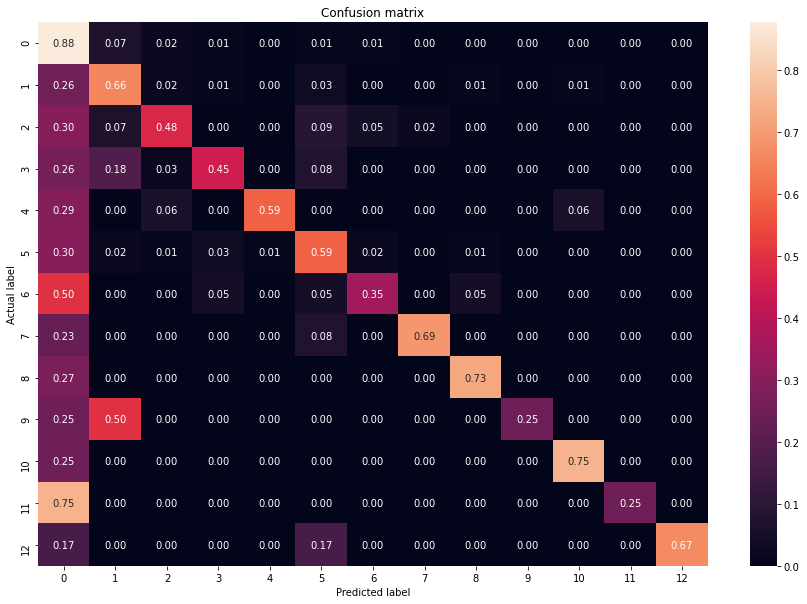

In [20]:
plot_cm(label_test, kmean_pred_test)

## Random Forest

In [21]:
forest_cls = RandomForestClassifier(n_jobs = -1, n_estimators = 5)# , max_depth = 200 , random_state=0)
forest_cls.fit(data_train, label)

RandomForestClassifier(n_estimators=5, n_jobs=-1)

In [22]:
tree_pred = forest_cls.predict(data_train)
tree_mse = mean_squared_error(label, tree_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.05973578091385093

### Testing

In [23]:
tree_pred_test = forest_cls.predict(data_test)
tree_mse_test = mean_squared_error(label_test, tree_pred_test)
tree_rmse_test = np.sqrt(tree_mse_test)
tree_rmse_test

0.15636875283821863

In [24]:
conf_matrix = confusion_matrix(label_test.argmax(axis=1), tree_pred_test.argmax(axis=1))
acc = accuracy_score(label_test.argmax(axis=1), tree_pred_test.argmax(axis=1))
f1 = f1_score(label_test.argmax(axis=1), tree_pred_test.argmax(axis=1), average = None)

print('Acccuracy: ', acc)


Acccuracy:  0.7819025522041764


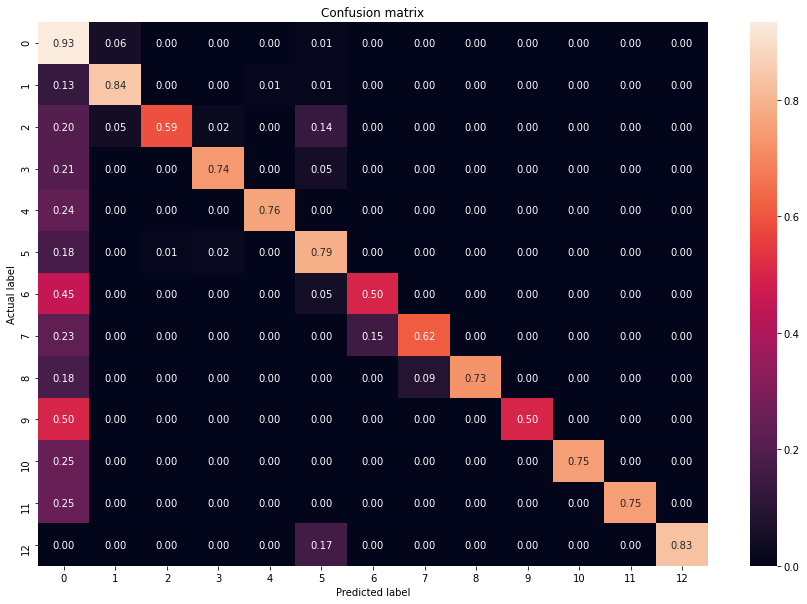

In [25]:
plot_cm(label_test, tree_pred_test)

## SVM

In [34]:
svm_model = SVC(kernel = 'poly', degree = 5, C = 100)

In [35]:
svm_model.fit(data_train, labels) 
svm_predictions = svm_model.predict(data_test)

conf_matrix = confusion_matrix(labels_test, svm_predictions)
acc = accuracy_score(labels_test, svm_predictions)
f1 = f1_score(labels_test, svm_predictions, average = None)

print('Acccuracy: ', acc)

Acccuracy:  0.777262180974478


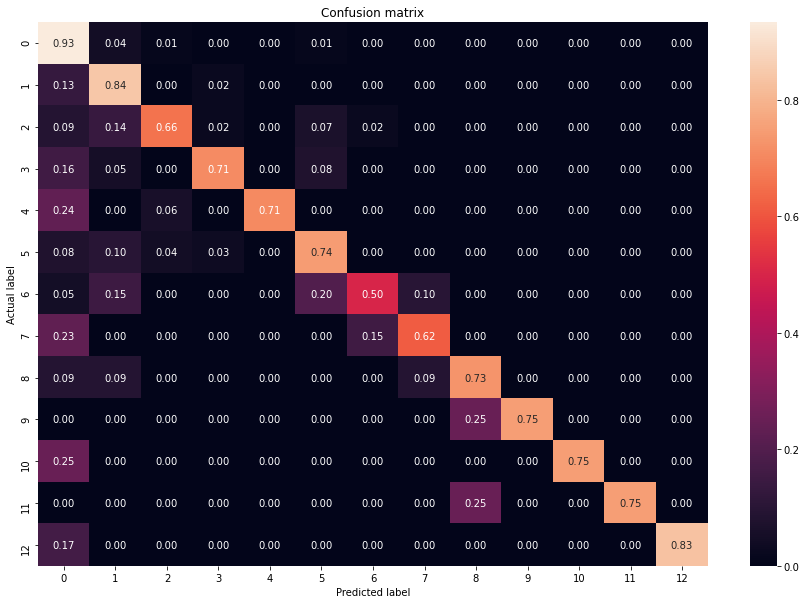

In [36]:
plot_cm(labels_test, svm_predictions)

## Bagging + Decision Tree

In [29]:
bag_clf = BaggingClassifier(
            DecisionTreeClassifier(), n_estimators=10,
            max_samples=100, bootstrap = True, n_jobs = -1)

In [30]:
bag_clf.fit(data_train, labels)
y_pred = bag_clf.predict(data_test)

### Testing

In [31]:
conf_matrix = confusion_matrix(label_test.argmax(axis=1), y_pred)
acc = accuracy_score(label_test.argmax(axis=1), y_pred)
f1 = f1_score(label_test.argmax(axis=1), y_pred, average = None)

print('Acccuracy: ', acc)


Acccuracy:  0.6078886310904872


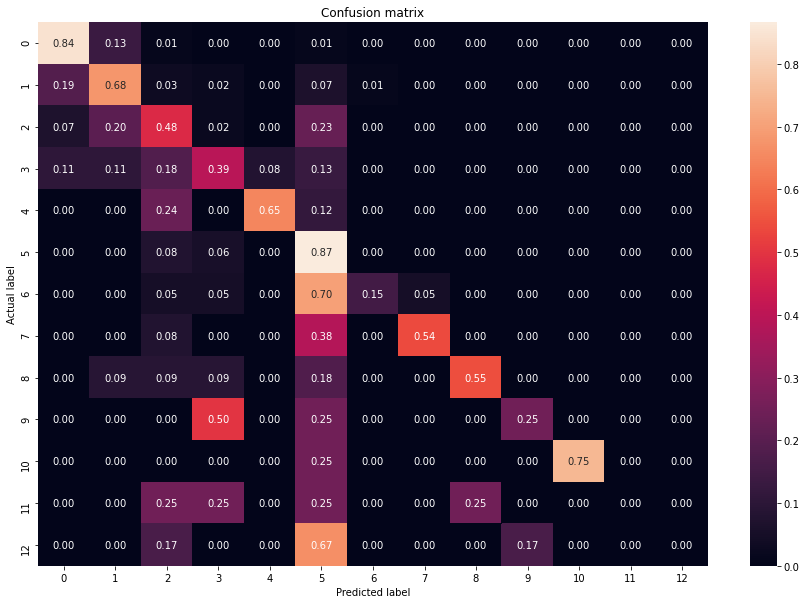

In [32]:
plot_cm(labels_test, y_pred)

## XGBoost

In [41]:
import xgboost as xgb

In [62]:
#xgb.booster.set_param({'predictor': 'gpu_predictor'})
#xgb.booster.inplace_predict(cupy_array)

#xgb.booster.set_param({'predictor': 'cpu_predictor})
#xgb.booster.inplace_predict(numpy_array)

In [42]:
y = tv_categorical['sold_quantity'].copy()
X = full_pipeline.transform(tv_categorical)

In [69]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [110]:
xg_cls = xgb.XGBClassifier(objective ='multi:softmax', n_jobs = -1, colsample_bytree = 0.3, learning_rate = 0.08,
                max_depth = 12, n_estimators = 16)

In [111]:
xg_cls.fit(data_train,labels)

xgb_preds = xg_cls.predict(data_test)

In [112]:
conf_matrix = confusion_matrix(labels_test, xgb_preds)
acc = accuracy_score(labels_test, xgb_preds)

In [113]:
print("Accuracy: ", acc)

Accuracy:  0.8074245939675174


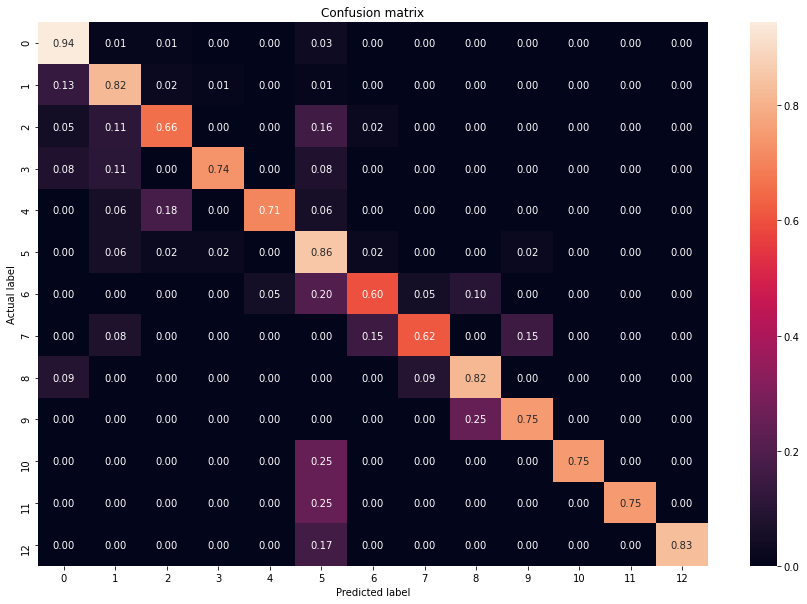

In [114]:
plot_cm(labels_test, xgb_preds)

### feature importance

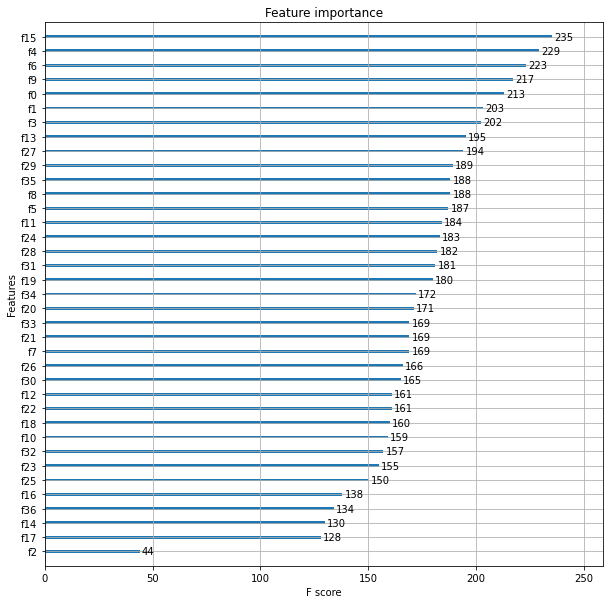

In [119]:
xgb.plot_importance(xg_cls)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [105]:
data_train.shape

(1703, 38)

# Predicting New Downloaded Samples

In [122]:
%load_ext autoreload
%autoreload 2
from modules.itemUtils import get_items

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
item_list = ['MLA822964501']
new_items = get_items(item_list)


In [124]:
new_items['sold_quantity']

0    5
Name: sold_quantity, dtype: int64

In [125]:
for cat in cat_attribbutes:
    new_items[cat].fillna('other', inplace=True)
    
for cat in ord_attribbutes:
    new_items[cat].fillna(0, inplace=True)

new_items = new_items.astype({"seller_years_active": int})
new_items_cat = get_dummies.transform(new_items[cat_attribbutes + ord_attribbutes].values)

new_items_dummies = pd.concat([new_items[other_attribbutes], new_items_cat ], axis=1)

In [126]:
new_items_dummies = full_pipeline.transform(new_items_dummies)

In [127]:
xg_cls.predict(new_items_dummies)

array([5.])

In [128]:
forest_cls.predict(data_test[:2]).argmax(axis=1)

array([5, 3], dtype=int64)

# Cross Validation - Performance

In [37]:
dataset = sample_cat(tv_categorical, 42, efective_sample = 450)

In [38]:
num_pipeline_cv = Pipeline([
    ('selector', NumericalCategoricalSelector(num_features, len(num_features))),
    ('imputer', SimpleImputer(strategy='constant', fill_value = 0)),
    ('std_scaler', StandardScaler()),
])

cat_pipeline_cv = Pipeline([
    ('selector', NumericalCategoricalSelector(cat_features, categorical_dimension)),
    ('dimension_reducer', DimensionReducer(feature_dimension = categorical_dimension, h_layers =(128, 64), latent_dim = 32))#303
])

full_pipeline_cv  = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline_cv),
    ('cat_pipeline', cat_pipeline_cv),
])

In [39]:
labels = dataset['sold_quantity'].copy()
data = full_pipeline_cv.fit_transform(dataset)


Train on 2134 samples
Epoch 1/25
2134/2134 [==============================] - 2s 768us/sample - loss: 0.0884
Epoch 2/25
2134/2134 [==============================] - 1s 308us/sample - loss: 0.0107
Epoch 3/25
2134/2134 [==============================] - 1s 246us/sample - loss: 0.0085
Epoch 4/25
2134/2134 [==============================] - 0s 170us/sample - loss: 0.0072
Epoch 5/25
2134/2134 [==============================] - 0s 173us/sample - loss: 0.0062
Epoch 6/25
2134/2134 [==============================] - 0s 183us/sample - loss: 0.0056
Epoch 7/25
2134/2134 [==============================] - 0s 166us/sample - loss: 0.0051
Epoch 8/25
2134/2134 [==============================] - 0s 170us/sample - loss: 0.0046
Epoch 9/25
2134/2134 [==============================] - 0s 206us/sample - loss: 0.0043
Epoch 10/25
2134/2134 [==============================] - 0s 172us/sample - loss: 0.0040
Epoch 11/25
2134/2134 [==============================] - 0s 170us/sample - loss: 0.0037
Epoch 12/25
2134/21

In [40]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
label = enc.fit_transform(np.array(labels).reshape(-1, 1))

In [48]:
#models
neigh_cv = KNeighborsClassifier(n_neighbors=5, n_jobs = -1)
forest_cls_cv = RandomForestClassifier(n_jobs = -1, n_estimators = 5)
dtree_cv = DecisionTreeClassifier(random_state=7)

svm_model_cv = SVC(kernel = 'poly', degree = 5, C = 100)
bag_clf_cv = BaggingClassifier(
            DecisionTreeClassifier(), n_estimators=10,
            max_samples=100, bootstrap = True, n_jobs = -1)

In [49]:
model_dic = {'KNN': neigh_cv, 'DecisionTree': dtree_cv, 'RandomForest': forest_cls_cv, 'Bagging': bag_clf_cv, 'SVM':svm_model_cv}
scoring = ["f1_macro", "accuracy"]

scores_table = pd.DataFrame(columns = ['modelo', 'fit_time', 'score_time', 'test_f1_macro', 'test_accuracy', 'Throughput'])

for model in model_dic.keys():
    if model == 'SVM' or model == 'Bagging':
        scores = cross_validate(model_dic[model], data, labels, scoring=scoring, cv=5, n_jobs = -1)
    else:
        scores = cross_validate(model_dic[model], data, label, scoring=scoring, cv=5, n_jobs = -1)
        
    score_df = pd.DataFrame(pd.DataFrame(scores).mean()).T
    score_df['modelo'] = model
    
    #StratifiedShuffleSplit, usado por cross_validate, por default splitea data en 0.1 para test
    score_df['Throughput'] = (data.shape[0] * 0.1) / score_df['score_time'] 
    score_df[['modelo', 'fit_time', 'score_time', 'test_f1_macro', 'test_accuracy', 'Throughput']]
    

    scores_table = pd.concat([scores_table, score_df], ignore_index=True)

In [50]:
scores_table.sort_values(by=['test_f1_macro'], ascending=False)

,modelo,fit_time,score_time,test_f1_macro,test_accuracy,Throughput
4,SVM,0.275518,0.027372,0.783297,0.783041,7796.158413
3,Bagging,0.110685,0.110686,0.488290,0.618564,1927.974497
1,DecisionTree,0.115681,0.004995,0.098814,0.543377,42719.762963
2,RandomForest,0.110888,0.117482,0.093049,0.474982,1816.455196
0,KNN,0.030768,0.379811,0.078625,0.370528,561.858185


**Para el analisis de performance se dividio el dataset en 5 subsets distintos llamados folds. Luego se entreno y evaluo cada modelo 5 veces, con un subset de datos distinto cada vez.**

**De estas corridas se tomo el accuracy, el f1 score, el tiempo de evaluacion y el throughput (items/seg).**

**De estas 5 corridas, SVM presento medidas mas estables de accuracy y f1_macro. Esto implica que no solo el accuracy es bueno, sino que tambien nos asegura que tanto el recall como la precision son cercanas entre ellas y la performance del accuracy no se debe exclusivamente al aporte de alguna de las clases mayoritarias frente al resto. A su vez posee el segundo mejor tiempo de evaluacion y throughput de los metodos eexplorados.** 